# Important libraries

In [13]:
import win32com.client
import sys
import time
import os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import math
import matplotlib.pyplot as plt

# Openserver Setup

Openserver class with methods to connect to the server, send commands, and disconnect from the server.

In [14]:
class OpenServer():
    "Class for holding ActiveX reference. Allows license disconnectio"
    def __init__(self):
        self.status = "Disconnected"
        self.OSReference = None
    
    def Connect(self):
        self.OSReference = win32com.client.Dispatch("PX32.OpenServer.1")
        self.status = "Connected"
        print("OpenServer connected")
        
    def Disconnect(self):
        self.OSReference = None
        self.status = "Disconnected"
        print("OpenServer disconnected")

In [15]:
def GetAppName(sv):
    # function for returning app name from tag string
    pos = sv.find(".")
    if pos < 2:
        sys.exit("GetAppName: Badly formed tag string")
    app_name = sv[:pos]
    if app_name.lower() not in ["prosper", "mbal", "gap", "pvt", "resolve",
                                   "reveal"]:
        sys.exit("GetAppName: Unrecognised application name in tag string")
    return app_name


def DoCmd(OpenServe, cmd):
    # perform a command and check for errors
    lerr = OpenServe.OSReference.DoCommand(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoCmd: " + err)


def DoSet(OpenServe, sv, val):
    # set a value and check for errors
    lerr = OpenServe.OSReference.SetValue(sv, val)
    app_name = GetAppName(sv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSet: " + err)
    
def DoGet(OpenServe, gv):
    # get a value and check for errors
    get_value = OpenServe.OSReference.GetValue(gv)
    app_name = GetAppName(gv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGet: " + err)
    return get_value


def DoSlowCmd(OpenServe, cmd):
    # perform a command then wait for command to exit and check for errors
    step = 0.001
    app_name = GetAppName(cmd)
    lerr = OpenServe.OSReference.DoCommandAsync(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)
    while OpenServe.OSReference.IsBusy(app_name) > 0:
        if step < 2:
            step = step*2
        time.sleep(step)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)


def DoGAPFunc(OpenServe, gv):
    DoSlowCmd(gv)
    DoGAPFunc = DoGet(OpenServe, "GAP.LASTCMDRET")
    lerr = OpenServe.OSReference.GetLastError("GAP")
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGAPFunc: " + err)
    return DoGAPFunc


def OSOpenFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.OPENFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSOpenFile: " + err)


def OSSaveFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.SAVEFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSSaveFile: " + err)

# Multiple well calculation

In [16]:
#gas availability and increment steps
number_of_wells = int(input('Please enter the number of wells:'))
gas_available = float(input('Please enter available gas'))
increment = float(input('Please enter the increment value'))
gas_injection_array = np.arange(0, gas_available + increment, increment)
df=pd.DataFrame()
df['gas_injection_array'] = gas_injection_array
df

,gas_injection_array
0,0.00
1,0.05
2,0.10
3,0.15
4,0.20
5,0.25
6,0.30
7,0.35
8,0.40
9,0.45


In [17]:
# os.chdir(r'C:\Users\Mehdi\Desktop\Desktop2\Desktop1\Data Science\Projects\KL project\GAS LIFT OPTIMIZATION')
os.chdir(r'C:\Users\aliyu\PycharmProjects\openserver_with_python')

In [18]:
# Initialises an 'OpenServer' class

petex = OpenServer()

# Creates ActiveX reference and holds a license

petex.Connect()
oil_rates_for_wells = {}

# Perform functions

cwd = os.getcwd()
for j in range(1,number_of_wells+1):
    #opening well file
    OSOpenFile(petex, cwd + f'\models\well_{j}.Out', 'PROSPER')
    print(f'Well {j} opened')
    #oil rates calculation
    for i in range(0,len(gas_injection_array)):
        command = f'PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals[{i}]'
        DoSet(petex, command,gas_injection_array[i])
    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
    oil_rates = [] #list of oil rates for 1 well
    for i in range(0, len(gas_injection_array)):
        value = f'PROSPER.OUT.SYS.Results[{i}].Sol.OilRate'
        oil_rates.append(np.round(float(DoGet(petex, value)),2))
    oil_rates_for_wells[f'well_{j}'] = oil_rates
    #closing file   
    OSSaveFile(petex, cwd + f'\well_{j}.Out', 'PROSPER')
    print(f'Well {j} closed')

#merging to main dataframe
for i in range(1,number_of_wells+1):
    df[f'Well_{i}'] = oil_rates_for_wells[f'well_{i}']

df.head()

OpenServer connected
Well 1 opened
Well 1 closed
Well 2 opened
Well 2 closed
Well 3 opened
Well 3 closed
Well 4 opened


KeyboardInterrupt: 

In [ ]:
#sensisitivity plot if all wells receive equal amount of gas
fig = go.Figure()
for i in range(1,number_of_wells+1):
    
    fig.add_trace(go.Scatter(x=df['gas_injection_array'], y=df[f'Well_{i}'],
                            mode='lines', name=f'Well_{i}'))
fig.update_layout(title='Sensitivity Plot(all wells receive equal amount of gas lift)',
                   xaxis_title='Gaslift Gas Injection Rate(MMscf/day)',
                   yaxis_title='Oil Rate(STB/day)',
                   title_x=0.5, 
                   )
fig.update_xaxes(nticks=50)
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
#extracting max gas lift oil rate pairs
df_new = df.drop('gas_injection_array', axis=1)
wells = []
i=1
for element in df_new.idxmax():
    oil_rate = df_new[f'Well_{i}'][element]
    gas_lift = df['gas_injection_array'][element]
    wells.append({'production_rate':oil_rate, 'gas_lift':gas_lift})
    i+=1
wells

[{'production_rate': 985.32, 'gas_lift': 1.5},
 {'production_rate': 1717.55, 'gas_lift': 1.4000000000000001},
 {'production_rate': 1643.5, 'gas_lift': 1.5},
 {'production_rate': 1447.71, 'gas_lift': 1.5},
 {'production_rate': 1101.44, 'gas_lift': 1.5},
 {'production_rate': 1904.17, 'gas_lift': 1.2000000000000002},
 {'production_rate': 1819.58, 'gas_lift': 1.25},
 {'production_rate': 1223.78, 'gas_lift': 1.5},
 {'production_rate': 1775.91, 'gas_lift': 1.3},
 {'production_rate': 1802.58, 'gas_lift': 1.3}]

In [ ]:
# wells = [{'production_rate': 987.44, 'gas_lift': 1.7},
#          {'production_rate': 1717.55, 'gas_lift': 1.4},
#          {'production_rate': 1643.5, 'gas_lift': 1.5},
#          {'production_rate': 1448.2, 'gas_lift': 1.7},
#          {'production_rate': 1104.21, 'gas_lift': 1.9},
#          {'production_rate': 1904.17, 'gas_lift': 1.2},
#          {'production_rate': 1819.56, 'gas_lift': 1.3},
#          {'production_rate': 1225.93, 'gas_lift': 1.9},
#          {'production_rate': 1775.91, 'gas_lift': 1.3},
#          {'production_rate': 1802.58, 'gas_lift': 1.3}]
#copy and paste the values from above based on number of wells determineed
wells = [
 {'production_rate': 985.32, 'gas_lift': 1.5},
 {'production_rate': 1717.55, 'gas_lift': 1.4000000000000001},
 {'production_rate': 1643.5, 'gas_lift': 1.5},
 {'production_rate': 1447.71, 'gas_lift': 1.5},
 {'production_rate': 1101.44, 'gas_lift': 1.5},
 {'production_rate': 1904.17, 'gas_lift': 1.2000000000000002},
 {'production_rate': 1819.58, 'gas_lift': 1.25},
 {'production_rate': 1223.78, 'gas_lift': 1.5},
 {'production_rate': 1775.91, 'gas_lift': 1.3},
 {'production_rate': 1802.58, 'gas_lift': 1.3}]
well_list = [(d['production_rate'], d['gas_lift']) for d in wells]
well_list

[(985.32, 1.5),
 (1717.55, 1.4000000000000001),
 (1643.5, 1.5),
 (1447.71, 1.5),
 (1101.44, 1.5),
 (1904.17, 1.2000000000000002),
 (1819.58, 1.25),
 (1223.78, 1.5),
 (1775.91, 1.3),
 (1802.58, 1.3)]

# Particle Swarm Optimization (PSO)

# Current solution with PSO

In [ ]:
import numpy as np
import random

def optimize_gas_allocation_PSO(wells, gas_capacity, iteration_count, num_particles):
    # Initialize the particles and their velocities
    particles = [np.random.rand(len(wells)) for _ in range(num_particles)]
    velocities = [np.zeros(len(wells)) for _ in range(num_particles)]

    # Initialize the best position and best fitness for each particle
    personal_best_positions = particles.copy()
    personal_best_fitness = [np.inf for _ in range(num_particles)]

    # Initialize the global best position and global best fitness
    global_best_position = personal_best_positions[np.argmin(personal_best_fitness)]
    global_best_fitness = np.inf

    # Run the algorithm for the specified number of iterations
    for i in range(iteration_count):
        # Update the position and fitness of each particle
        for j, particle in enumerate(particles):
            # Update the velocity of the particle
            rp = random.uniform(0,1)
            rg = random.uniform(0,1)
            velocities[j] = 0.5 * velocities[j] + rp * (personal_best_positions[j] - particle) + rg * (global_best_position - particle)
            # Update the position of the particle
            particles[j] += velocities[j]
            # Ensure that the particle's position is within the constraints
            particles[j] = np.maximum(np.zeros(len(wells)), particles[j])

            # Calculate the fitness of the particle
            fitness = -1 * np.sum(particles[j] * [well['production_rate'] for well in wells])
            # Update the personal best position and personal best fitness of the particle
            if fitness < personal_best_fitness[j]:
                personal_best_positions[j] = particles[j]
                personal_best_fitness[j] = fitness

            # Check if the total gas allocated to all wells is less than or equal to the total available gas capacity
            total_gas_allocated = sum(particles[j])
            if total_gas_allocated > gas_capacity:
                particles[j] = particles[j] * (gas_capacity / total_gas_allocated)
                total_gas_allocated = gas_capacity

            # Update the global best position and global best fitness
            if fitness < global_best_fitness:
                global_best_position = particles[j]
                global_best_fitness = fitness
    return [{'well_id': j, 'allocation': global_best_position[j]} for j in range(len(wells))]


# Testing the current solution

In [ ]:
gas_capacity= 1.5
iteration_count= 50
num_part = 240
allocations = optimize_gas_allocation_PSO(wells, gas_capacity, iteration_count, num_part)
allocations

[{'well_id': 0, 'allocation': 0.11856672957678785},
 {'well_id': 1, 'allocation': 0.22317546050798243},
 {'well_id': 2, 'allocation': 0.13624595549550425},
 {'well_id': 3, 'allocation': 0.16642961981824633},
 {'well_id': 4, 'allocation': 0.22977984673849056},
 {'well_id': 5, 'allocation': 0.09986468048060859},
 {'well_id': 6, 'allocation': 0.12270733767742853},
 {'well_id': 7, 'allocation': 0.11888142600872491},
 {'well_id': 8, 'allocation': 0.1278026399848467},
 {'well_id': 9, 'allocation': 0.15654630371137998}]

In [ ]:
#total gas consumed
sum_gas = 0
for alloc in allocations:
    sum_gas+=alloc['allocation']
print(sum_gas)

1.5


In [ ]:
# test the accuracy of method-Matt
petex = OpenServer()

petex.Connect()
oil_rates = []

# Perform functions
cwd = os.getcwd()

for j in range(len(allocations)):
#opening well file
    OSOpenFile(petex, cwd + f'\models\well_{j+1}.Out', 'PROSPER')
    print(f'Well {j+1} opened')

    DoSet(petex,'PROSPER.ANL.SYS.Sens.SensDB.Clear',0)
    DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Vars[0]",22)
    
    DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals["+str(0)+"]",allocations[j]['allocation'])

    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
     
    
    oil_rates.append((np.round(float(DoGet(petex, 'PROSPER.OUT.SYS.Results[0].Sol.OilRate')),2),allocations[j]['allocation']))
    

petex.Disconnect()

oil_rates

OpenServer connected
Well 1 opened
Well 2 opened
Well 3 opened
Well 4 opened
Well 5 opened
Well 6 opened
Well 7 opened
Well 8 opened
Well 9 opened
Well 10 opened
OpenServer disconnected


[(898.97, 0.11856672957678785),
 (1679.65, 0.22317546050798243),
 (1591.84, 0.13624595549550425),
 (1383.74, 0.16642961981824633),
 (1031.34, 0.22977984673849056),
 (1867.22, 0.09986468048060859),
 (1779.74, 0.12270733767742853),
 (1142.52, 0.11888142600872491),
 (1732.79, 0.1278026399848467),
 (1764.44, 0.15654630371137998)]

In [ ]:
sum([x[0] for x in oil_rates]),sum([x[1] for x in oil_rates])

(14872.250000000002, 1.5)

# Visualize the current solution

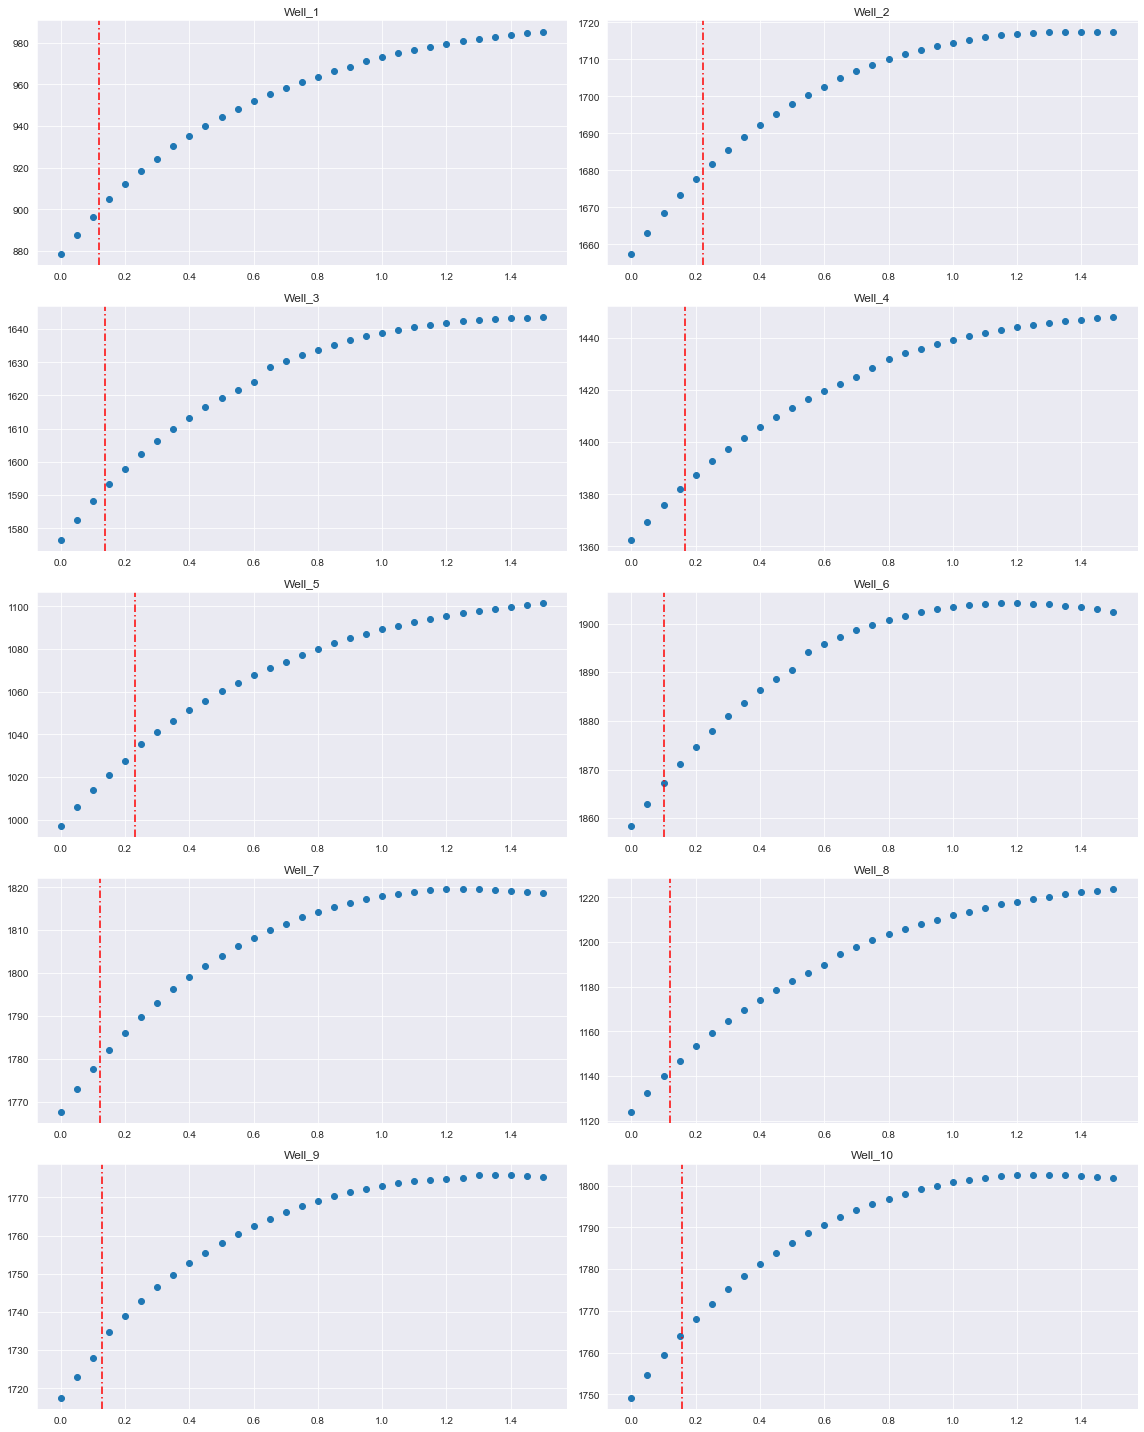

In [ ]:
cols = 2
rows = math.ceil(len(allocations)/cols)
fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize=(16,20))

for i in range(number_of_wells):
    k = i//2
    j = i%2
    
    x=df['gas_injection_array'] 
    y=df[f'Well_{i+1}']
    label=f'Well_{i+1}' 
    
    axs[k,j].plot(x,y,'o')
    axs[k,j].set_title(label)
    axs[k,j].axvline(oil_rates[i][1],c='r', dashes=(5,2,1,2))
    
    fig.tight_layout()
plt.show()